# Capstone Project - Credit Card Fraud Detection

## 3. RandomUnderSampling_IQR

We will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting. In this case, we are undersampling the majority class, which is the non-fraud cases to adjsut imbalanced data. This technique will take random draws from the non-fraud observations, to match the occurences of fraud observations. 

Like what we did we SMOTE, after removal of outliers, we will run a single model for each of the following classifiers:

1. Logistic Regression
2. Optimized Logistic Regression
3. Naive Bayes
4. Decision Tree
5. Random Forest 

In [1]:
! pip install scikit-plot
! pip install imblearn

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import scipy
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

%matplotlib inline

from pprint import pprint
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from itertools import product

In [2]:
df = pd.read_csv('../assets/creditcard.csv')

In [3]:
# Scale columns 'Amount' and 'Time'
std_scaler = StandardScaler()

df['amount_scaled'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['time_scaled'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             284807 non-null  float64
 1   V2             284807 non-null  float64
 2   V3             284807 non-null  float64
 3   V4             284807 non-null  float64
 4   V5             284807 non-null  float64
 5   V6             284807 non-null  float64
 6   V7             284807 non-null  float64
 7   V8             284807 non-null  float64
 8   V9             284807 non-null  float64
 9   V10            284807 non-null  float64
 10  V11            284807 non-null  float64
 11  V12            284807 non-null  float64
 12  V13            284807 non-null  float64
 13  V14            284807 non-null  float64
 14  V15            284807 non-null  float64
 15  V16            284807 non-null  float64
 16  V17            284807 non-null  float64
 17  V18            284807 non-nul

## Modeling

We will run a single model for each of the following classifiers:

1. Logistic Regression
2. Optimized Logistic Regression
3. Naive Bayes
4. Decision Tree
5. Random Forest 

An initial loading and splitting of the dataset were performed to train and test the baseline logistic regression model.

## Train/Test split

In [4]:
X = df.drop('Class',axis=1) # independent columns - features
y = df.loc[:,'Class']       # target column - Class

In [5]:
print("Input Shape : ", X.shape)
print("Output Shape : ", y.shape)

Input Shape :  (284807, 30)
Output Shape :  (284807,)


In [6]:
#Train test split into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [7]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(213605, 30) (71202, 30) (213605,) (71202,)


## Model 1: Baseline Logistic Regression Model

In [8]:
# Create baseline logistic regression classifier
lr = LogisticRegression()

# Fit training data and training labels
lr.fit(X_train, y_train)

LogisticRegression()

### Baseline score

In [9]:
print(f'Training accuracy: {lr.score(X_train, y_train)}')
print(f'Testing accuracy: {lr.score(X_test, y_test)}')

Training accuracy: 0.999246272325086
Testing accuracy: 0.9991432824920649


Due to the heavily imbalanced dataset, the baseline logistic regression model was able to classify every training point and testing point almost perfectly. With a distribution of 99.83 % representing the majority class (ie. non-fraudulent transactions), a correct prediction will be made almost 100% of the time.

## Random Under Sampling Using imblearn library

In [10]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
xr,yr = nm.fit_sample(X, y)

from collections import Counter
print('Original Count: {}'.format(Counter(y)))
print('Sampled Count: {}'.format(Counter(yr)))

# Now we have equal fraud and non fraud data.

new_df = pd.concat([pd.DataFrame(xr,columns=X.columns),pd.DataFrame(yr)],axis=1)

new_df = new_df.rename({0:'Class'},axis=1)

new_df.head()

Original Count: Counter({0: 284315, 1: 492})
Sampled Count: Counter({0: 492, 1: 492})


V1        V2        V3        V4        V5        V6        V7  \
0  1.461443 -0.582645 -2.297665  1.089190  0.054096 -1.349453  0.724947   
1  1.719332  1.028017 -2.056034  4.206490  1.101320 -0.713744  0.672316   
2  1.710412 -0.177393 -2.423228  0.851039  0.570935 -0.825292  0.500599   
3  1.770391 -0.043727 -2.141603  0.927294  0.326160 -1.265856  0.526820   
4  1.600837 -0.566270 -2.067152  0.523750  0.242095 -0.662067  0.412231   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0 -0.429395  0.788068 -1.162223  ... -0.314868 -0.188230 -0.098629  0.084687   
1 -0.140571 -1.506492  0.325083  ... -0.766599  0.117322 -0.242448 -0.108112   
2 -0.273878  0.775121 -1.171742  ... -0.316022 -0.057084  0.443548  0.156303   
3 -0.383667  0.738697 -1.109431  ... -0.181550 -0.054756 -0.223937  0.155648   
4 -0.266734  0.862860 -1.038563  ... -0.568326  0.004750  0.508183 -0.096610   

        V26       V27       V28  amount_scaled  time_scaled  Class  
0 -0.328303 -0.036457  0.041937       0.831044     1.098995      0  
1 -0.207626 -0.031489  0.022199      -0.019789     0.998338      0  
2 -0.336014 -0.012914  0.028351       0.337160     0.872896      0  
3 -0.302637  0.000238  0.013488       0.185593     0.502171      0  
4 -0.138248 -0.043426  0.027720       0.575806     1.099374      0  

[5 rows x 31 columns]

## Correlation Matrices

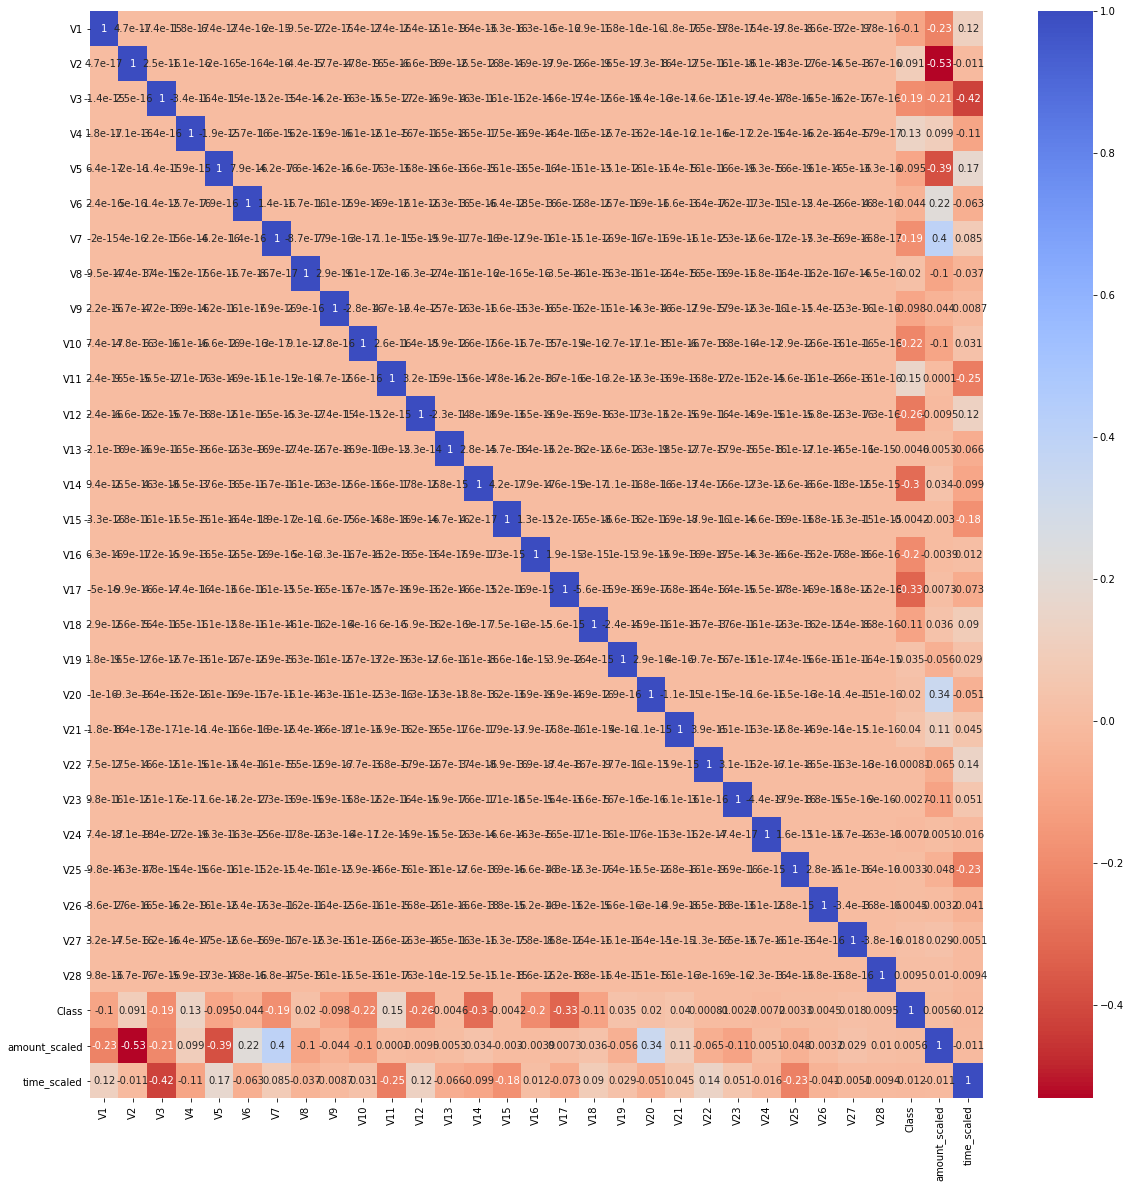

In [11]:
#for Original Data frame

plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm_r')

In [12]:
#For new sampled (undersampling) df

plt.figure(figsize=(20,20))
sns.heatmap(new_df.corr(),annot=True,cmap='coolwarm_r')

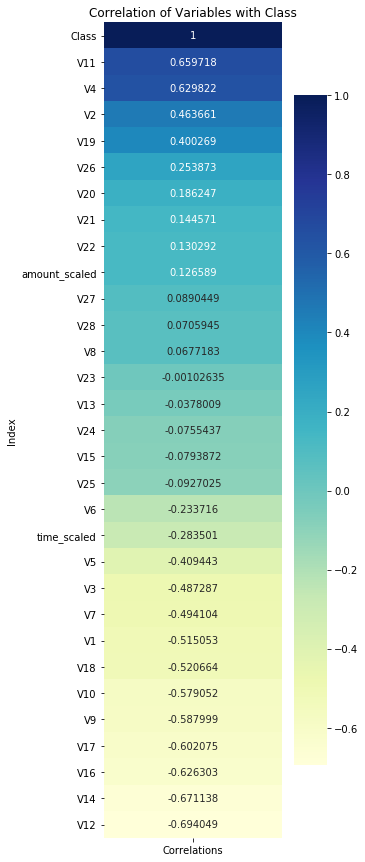

In [13]:
corr = new_df.corrwith(new_df['Class']).reset_index()
corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)
plt.figure(figsize=(4,15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Correlation of Variables with Class")
plt.show()

For each of the top 4 highest positive and negative correlations, we would create box plots to helps us visualize the extent of outliers.

Positive correlation: The higher the feature value, the probability increases that it will be a fraudulent transaction. The 4 highest positively correlated features are: V11, V4, V2, V19. 

Negative correlation: The lower the feature value, the probability decreases that it will be a fraudulent transaction. The 4 highest negatively correlated features are: V17, V16, V14, V12.  

Using SMOTE: 
- The 4 highest positively correlated features are: V4, V11, V2, V19. 
- The 4 highest negatively correlated features are: V16, V10, V12, V14. 

From here we can see that the results are very similar even we use two different types of resampling methods. 

In the below, we will create box plots to helps us visualize the extent of outliers.

### Box Plots

Box plots are useful as they show outliers for integer data types within a data set. An outlier is an observation that is numerically distant from the rest of the data. When reviewing a box plot, an outlier is defined as a data point that is located outside the whiskers of the box plot.

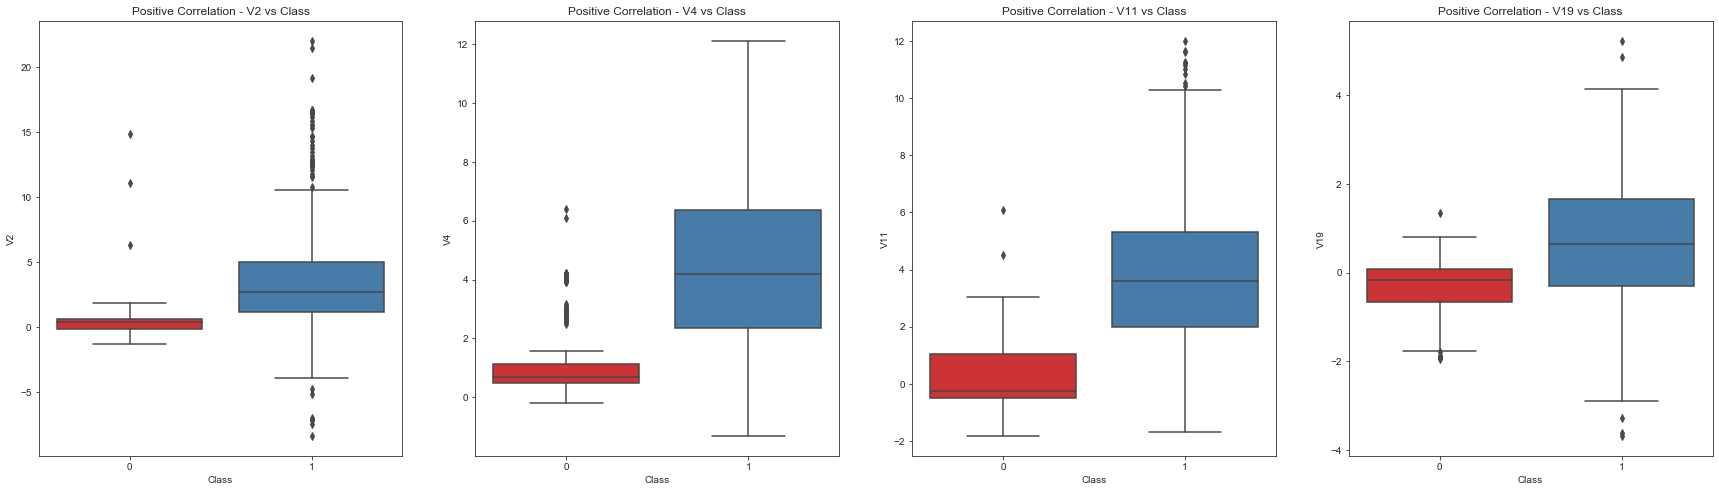

In [14]:
sns.set_style('ticks')
f, axes = plt.subplots(ncols=4, figsize=(30,8))

sns.boxplot(x='Class', y='V11', data=new_df, palette='Set1', ax=axes[2])
axes[2].set_title('Positive Correlation - V11 vs Class')

sns.boxplot(x='Class', y='V4', data=new_df, palette='Set1', ax=axes[1])
axes[1].set_title('Positive Correlation - V4 vs Class')

sns.boxplot(x='Class', y='V2', data=new_df, palette='Set1', ax=axes[0])
axes[0].set_title('Positive Correlation - V2 vs Class')

sns.boxplot(x='Class', y='V19', data=new_df, palette='Set1', ax=axes[3])
axes[3].set_title('Positive Correlation - V19 vs Class')

plt.show()

In [15]:
f, axes = plt.subplots(ncols=4, figsize=(30,8))

sns.boxplot(x='Class', y='V17', data=new_df, palette='husl', ax=axes[0])
axes[0].set_title('Negative Correlation - V17 vs Class')

sns.boxplot(x='Class', y='V16', data=new_df, palette='husl', ax=axes[3])
axes[3].set_title('Negative Correlation - V16 vs Class')

sns.boxplot(x='Class', y='V14', data=new_df, palette='husl', ax=axes[2])
axes[2].set_title('Negative Correlation - V14 vs Class')

sns.boxplot(x='Class', y='V12', data=new_df, palette='husl', ax=axes[1])
axes[1].set_title('Negative Correlation - V12 vs Class')

plt.show()

### Distribution Plot

A distribution plot displays the variation in the data distribution. By using the Seaborn library, an overall distribution of continuous data variables is represented by a histogram, combined with a line indicating the Gaussian (ie. normal) distribution.

In [16]:
print('Top 4 Features - Positive Correlation with Class\n')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 6))

v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist, ax=ax3, fit=norm, color='#f0701a')
ax3.set_title('V11 Distribution \n (Fraudulent Transactions)', fontsize=14)

v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v4_fraud_dist, ax=ax2, fit=norm, color='#ee2424')
ax2.set_title('V4 Distribution \n (Fraudulent Transactions)', fontsize=14)

v2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(v2_fraud_dist, ax=ax1, fit=norm, color='#23b458')
ax1.set_title('V2 Distribution \n (Fraudulent Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist, ax=ax4, fit=norm, color='#2783d6')
ax4.set_title('V19 Distribution \n (Fraudulent Transactions)', fontsize=14)

plt.show()

Top 4 Features - Positive Correlation with Class



Top 4 Features - Negative Correlation with Class



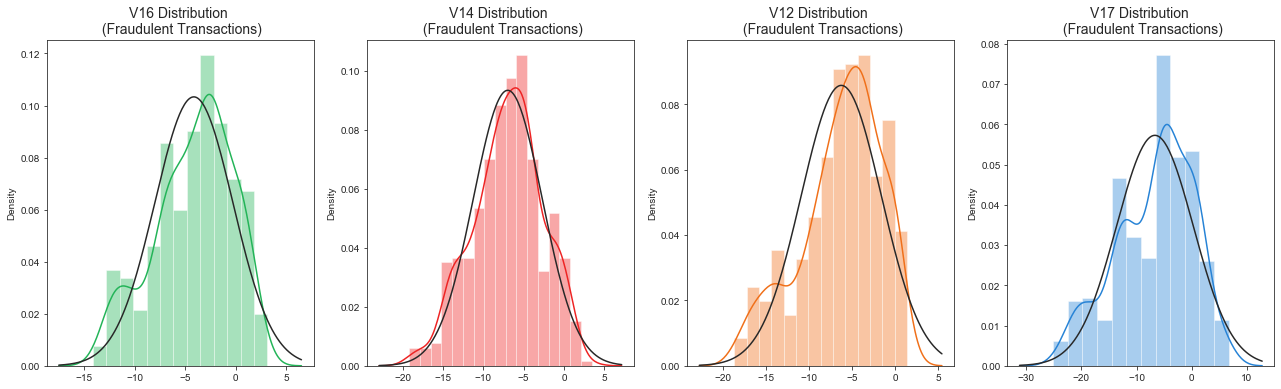

In [17]:
print('Top 4 Features - Negative Correlation with Class\n')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 6))

v17_fraud_dist = new_df['V17'].loc[new_df['Class'] == 1].values
sns.distplot(v17_fraud_dist, ax=ax4, fit=norm, color='#2783d6')
ax4.set_title('V17 Distribution \n (Fraudulent Transactions)', fontsize=14)

v16_fraud_dist = new_df['V16'].loc[new_df['Class'] == 1].values
sns.distplot(v16_fraud_dist, ax=ax1, fit=norm, color='#23b458')
ax1.set_title('V16 Distribution \n (Fraudulent Transactions)', fontsize=14)

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax2, fit=norm, color='#ee2424')
ax2.set_title('V14 Distribution \n (Fraudulent Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax3, fit=norm, color='#f0701a')
ax3.set_title('V12 Distribution \n (Fraudulent Transactions)', fontsize=14)


plt.show()

### Removal of Extreme Outliers

In order to obtain a good model performance, there is a need to identify and remove extreme outliers from features that have a high correlation with our classes. This clean-up process helps to ensure that the observations best represent the problem.

One of the techniques is to use the Interquartile Range Method (IQR).

The threshold for removing outliers has been determined at 1.5 to prevent the risk of information loss, which will cause the models to have a lower accuracy (ie. under-fitting).

In [18]:
print('Removal of Extreme Outliers from Top 4 Features which are Positively Correlated with Class\n')

# V11 - Removing extreme outliers from fraudulent transactions
print('V11 Analysis')
v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v11_iqr = q75 - q25
print('IQR: {}'.format(v11_iqr))

v11_cut_off = v11_iqr * 1.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('Cut-Off: {}'.format(v11_cut_off))
print('Lower Limit: {}'.format(v11_lower))
print('Upper Limit: {}'.format(v11_upper))

outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V11'] > v11_upper) | (new_df['V11'] < v11_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V4 - Removing extreme outliers from fraudulent transactions
print('V4 Analysis')
v4_fraud = new_df['V4'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v4_iqr = q75 - q25
print('IQR: {}'.format(v4_iqr))

v4_cut_off = v4_iqr * 1.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
print('Cut-Off: {}'.format(v4_cut_off))
print('Lower Limit: {}'.format(v4_lower))
print('Upper Limit: {}'.format(v4_upper))

outliers = [x for x in v4_fraud if x < v4_lower or x > v4_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V4'] > v4_upper) | (new_df['V4'] < v4_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V2 - Removing extreme outliers from fraudulent transactions
print('V2 Analysis')
v2_fraud = new_df['V2'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v2_iqr = q75 - q25
print('IQR: {}'.format(v2_iqr))

v2_cut_off = v2_iqr * 1.5
v2_lower, v2_upper = q25 - v2_cut_off, q75 + v2_cut_off
print('Cut-Off: {}'.format(v2_cut_off))
print('Lower Limit: {}'.format(v2_lower))
print('Upper Limit: {}'.format(v2_upper))

outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V2'] > v2_upper) | (new_df['V2'] < v2_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V19 - Removing extreme outliers from fraudulent transactions
print('V19 Analysis')
v19_fraud = new_df['V19'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v19_fraud, 25), np.percentile(v19_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v19_iqr = q75 - q25
print('IQR: {}'.format(v19_iqr))

v19_cut_off = v19_iqr * 1.5
v19_lower, v19_upper = q25 - v19_cut_off, q75 + v19_cut_off
print('Cut-Off: {}'.format(v19_cut_off))
print('Lower Limit: {}'.format(v19_lower))
print('Upper Limit: {}'.format(v19_upper))

outliers = [x for x in v19_fraud if x < v19_lower or x > v19_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V19'] > v19_upper) | (new_df['V19'] < v19_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))

Removal of Extreme Outliers from Top 4 Features which are Positively Correlated with Class

V11 Analysis
25th Quartile: 1.973396660607005 | 75th Quartile: 5.307077600096335
IQR: 3.33368093948933
Cut-Off: 5.000521409233995
Lower Limit: -3.0271247486269903
Upper Limit: 10.30759900933033
Number of Outliers: 10
Number of Instances after Removing Outliers: 974


V4 Analysis
25th Quartile: 2.33144342069487 | 75th Quartile: 6.228090686894386
IQR: 3.8966472661995155
Cut-Off: 5.844970899299273
Lower Limit: -3.513527478604403
Upper Limit: 12.07306158619366
Number of Outliers: 1
Number of Instances after Removing Outliers: 973


V2 Analysis
25th Quartile: 1.1762702245705 | 75th Quartile: 4.64182734988813
IQR: 3.4655571253176305
Cut-Off: 5.198335687976446
Lower Limit: -4.022065463405946
Upper Limit: 9.840163037864576
Number of Outliers: 51
Number of Instances after Removing Outliers: 920


V19 Analysis
25th Quartile: -0.428087850292456 | 75th Quartile: 1.7840958284909576
IQR: 2.2121836787834135
Cu

In [19]:
print('Removal of Extreme Outliers from Top 4 Features which are Negatively Correlated with Class\n')

# V17 - Removing extreme outliers from fraudulent transactions
print('V17 Analysis')
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v17_iqr = q75 - q25
print('IQR: {}'.format(v17_iqr))

v17_cut_off = v17_iqr * 1.5
v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
print('Cut-Off: {}'.format(v17_cut_off))
print('Lower Limit: {}'.format(v17_lower))
print('Upper Limit: {}'.format(v17_upper))

outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V16 - Removing extreme outliers from fraudulent transactions
print('V16 Analysis')
v16_fraud = new_df['V16'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v16_fraud, 25), np.percentile(v16_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v16_iqr = q75 - q25
print('IQR: {}'.format(v16_iqr))

v16_cut_off = v16_iqr * 1.5
v16_lower, v16_upper = q25 - v16_cut_off, q75 + v16_cut_off
print('Cut-Off: {}'.format(v16_cut_off))
print('Lower Limit: {}'.format(v16_lower))
print('Upper Limit: {}'.format(v16_upper))

outliers = [x for x in v16_fraud if x < v16_lower or x > v16_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V16'] > v16_upper) | (new_df['V16'] < v16_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')


# V14 - Removing extreme outliers from fraudulent transactions
print('V14 Analysis')
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('IQR: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut-Off: {}'.format(v14_cut_off))
print('Lower Limit: {}'.format(v14_lower))
print('Upper Limit: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')


# V12 - Removing extreme outliers from fraudulent transactions
print('V12 Analysis')
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('IQR: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Cut-Off: {}'.format(v12_cut_off))
print('Lower Limit: {}'.format(v12_lower))
print('Upper Limit: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')




Removal of Extreme Outliers from Top 4 Features which are Negatively Correlated with Class

V17 Analysis
25th Quartile: -9.750776386541231 | 75th Quartile: -0.391051374531861
IQR: 9.35972501200937
Cut-Off: 14.039587518014056
Lower Limit: -23.790363904555285
Upper Limit: 13.648536143482195
Number of Outliers: 3
Number of Instances after Removing Outliers: 916


V16 Analysis
25th Quartile: -5.65999214495357 | 75th Quartile: -0.939367707744607
IQR: 4.720624437208963
Cut-Off: 7.080936655813445
Lower Limit: -12.740928800767016
Upper Limit: 6.141568948068838
Number of Outliers: 4
Number of Instances after Removing Outliers: 912


V14 Analysis
25th Quartile: -9.572938112392258 | 75th Quartile: -4.191355441597185
IQR: 5.381582670795073
Cut-Off: 8.072374006192609
Lower Limit: -17.64531211858487
Upper Limit: 3.881018564595424
Number of Outliers: 0
Number of Instances after Removing Outliers: 912


V12 Analysis
25th Quartile: -8.021620964921379 | 75th Quartile: -2.7249358141366447
IQR: 5.29668515

In [20]:
new_df.shape

(900, 31)

In [21]:
new_df['Class'].value_counts()

0    490
1    410
Name: Class, dtype: int64

In [22]:
X_clean = new_df.iloc[:,0:30] # independent columns - features
y_clean = new_df.iloc[:,30]   # target column - Class

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean,
                                                                            test_size = 0.2,
                                                                            random_state = 1)

In [23]:
print(X_train_clean.shape, y_train_clean.shape)
print(X_test_clean.shape, y_test_clean.shape)

(720, 30) (720,)
(180, 30) (180,)


## Model 2: Optimized Logistic Regression Model

In [24]:
# Set the model parameters for grid search
log_reg_params = {'penalty': ['l1', 'l2'], 
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Set up grid search meta-estimator
grid_search = GridSearchCV(LogisticRegression(), log_reg_params, 
                           n_jobs=-1, scoring='roc_auc', cv=3)

# Train the grid search meta-estimator to obtain optimal model
opt_lr = grid_search.fit(X_train_clean, y_train_clean)

# Print optimal hyperparameters
pprint(opt_lr.best_estimator_.get_params())

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [25]:
print(f'Optimized Logistic Regression Model Accuracy for train data: {opt_lr.score(X_train_clean, y_train_clean)}')
print(f'Optimized Logistic Regression Model Accuracy for test data: {opt_lr.score(X_test_clean, y_test_clean)}')

Optimized Logistic Regression Model Accuracy for train data: 0.9817360856579144
Optimized Logistic Regression Model Accuracy for test data: 0.9765171177851935


Compare to the baseline Logistic Regression model that hit 99.99%, which is an almost perfect 100%, optimized Logistic Regression model accuracy rate shows a more realistic fit of 98.1% accuracy hit for train data and 97.6% for test data.

## Model 3: Naïve Bayes Model

In [26]:
# Create Naive Bayes classifier
nb = BernoulliNB()

# Fit training data and training labels
nb.fit(X_train_clean, y_train_clean)

BernoulliNB()

In [27]:
print(f'Naive Bayes Model Accuracy for train data: {nb.score(X_train_clean, y_train_clean)}')
print(f'Naive Bayes Model Accuracy for test data: {nb.score(X_test_clean, y_test_clean)}')

Naive Bayes Model Accuracy for train data: 0.9138888888888889
Naive Bayes Model Accuracy for test data: 0.9111111111111111


As compared to both baseline and optimized logistic regression model, it appears that the naïve bayes model has a less ideal fit of the learning curve with a lower accuracy rate achieved by using the trained model on the test data, which is only 91% for both train and test dataset. 

## Model 4: Decision Tree Model

In [28]:
# Create Decision Tree classifier
dt = DecisionTreeClassifier()

# Fit training data and training labels
dt.fit(X_train_clean, y_train_clean)

DecisionTreeClassifier()

In [29]:
print(f'Decision Tree Model Accuracy for train data: {dt.score(X_train_clean, y_train_clean)}')
print(f'Decision Tree Model Accuracy for test data: {dt.score(X_test_clean, y_test_clean)}')

Decision Tree Model Accuracy for train data: 1.0
Decision Tree Model Accuracy for test data: 0.9388888888888889


As compared to the optimized Logistic Regression model and naive bayes model, it appears that the Decision Tree model has better performance in accuracy rate. It has 100% on the train data and 93.88% on test data.

## Model 5: Random Forest Model

In [30]:
# Create Random Forest classifier
rf = RandomForestClassifier()

# Fit training data and training labels
rf.fit(X_train_clean, y_train_clean)

RandomForestClassifier()

In [31]:
print(f'Random Forest Model Accuracy for train data: {rf.score(X_train_clean, y_train_clean)}')
print(f'Random Forest Model Accuracy for test data: {rf.score(X_test_clean, y_test_clean)}')

Random Forest Model Accuracy for train data: 1.0
Random Forest Model Accuracy for test data: 0.9611111111111111


Similar to Decision Tree model, Random Forest model has better performance in accuracy rate than logistic regression, optimized logistic regression and naive bayes models. It is also able to attain 100% accuracy rate in train data and 96.11% on test data.

Among all 5 models, Random Forest model has the highest accuracy rate.

## Performance Evaluation of Models

In [32]:
# Predict target variables (ie. labels) for each classifer
lr_classifier_name = ['Baseline Logistic Regression']
lr_predicted_labels = lr.predict(X_test)

opt_lr_classifier_name = ['Optimized Logistic Regression']
opt_lr_predicted_labels = opt_lr.predict(X_test_clean)

nb_classifier_name = ['Naive Bayes']
nb_predicted_labels = nb.predict(X_test_clean)

dt_classifier_name = ['Decision Tree']
dt_predicted_labels = dt.predict(X_test_clean)

rf_classifier_name = ['Random Forest']
rf_predicted_labels = rf.predict(X_test_clean)

#### 1. Classification Report

In [33]:
print("Classification Report for", lr_classifier_name, " :\n ",
      metrics.classification_report(y_test, lr_predicted_labels, 
                                    target_names=['Non-Fraudulent','Fraud']))
print('---' * 25)

print("Classification Report for ", opt_lr_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, opt_lr_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))
print('---' * 25)

print("Classification Report for ", nb_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, nb_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))

print('---' * 25)

print("Classification Report for ", dt_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, dt_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))

print('---' * 25)

print("Classification Report for ", rf_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, rf_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))


Classification Report for ['Baseline Logistic Regression']  :
                  precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     71079
         Fraud       0.84      0.62      0.71       123

      accuracy                           1.00     71202
     macro avg       0.92      0.81      0.86     71202
  weighted avg       1.00      1.00      1.00     71202

---------------------------------------------------------------------------
Classification Report for  ['Optimized Logistic Regression']  :
                  precision    recall  f1-score   support

Non-Fraudulent       0.89      1.00      0.94        93
         Fraud       1.00      0.87      0.93        87

      accuracy                           0.94       180
     macro avg       0.95      0.94      0.94       180
  weighted avg       0.95      0.94      0.94       180

---------------------------------------------------------------------------
Classification Report for  ['Naive Bayes

#### 2. Confusion Matrix

Confusion Matrix for ['Baseline Logistic Regression']


Confusion Matrix for ['Optimized Logistic Regression']


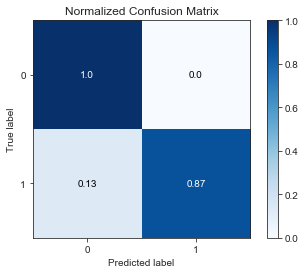

Confusion Matrix for ['Naive Bayes']


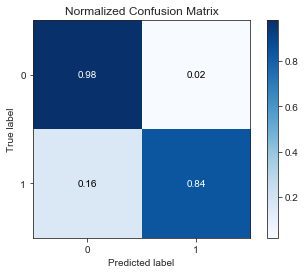

Confusion Matrix for ['Decision Tree']


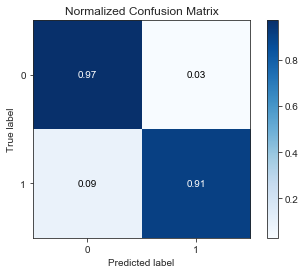

Confusion Matrix for RandomForestClassifier()


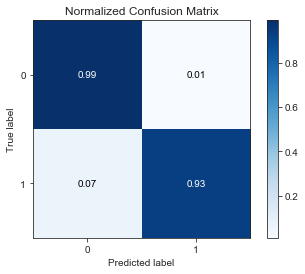

In [34]:
print("Confusion Matrix for", lr_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test, lr_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", opt_lr_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_clean, opt_lr_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", nb_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_clean, nb_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", dt_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_clean, dt_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", rf)
skplt.metrics.plot_confusion_matrix(y_test_clean, rf_predicted_labels, normalize=True)
plt.show()



#### 3. Precision-Recall Curve

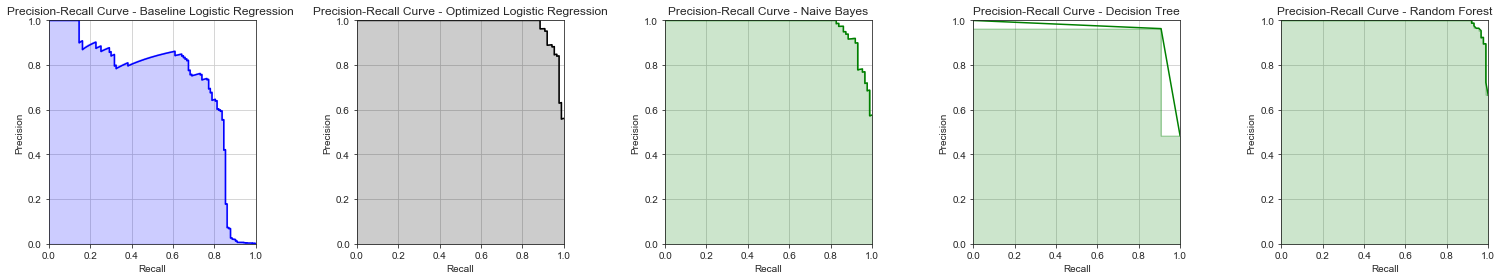

In [35]:

fig, axList = plt.subplots(ncols=5)
fig.set_size_inches(21,4)

# Plot the Precision-Recall curve for Baseline Logistic Regression  
ax = axList[0]
lr_predicted_proba = lr.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, lr_predicted_proba[:,1])
ax.plot(recall, precision,color='blue')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Baseline Logistic Regression ')
ax.step(recall, precision, color='blue', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
ax.grid(True)

# Plot the Precision-Recall curve for Optimized Logistic Regression
ax = axList[1]
opt_lr_predicted_proba = opt_lr.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, opt_lr_predicted_proba[:,1])
ax.plot(recall, precision,color='black')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Optimized Logistic Regression')
ax.step(recall, precision, color='black', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='black')
ax.grid(True)

# Plot the Precision-Recall curve for Naive Bayes
ax = axList[2]
nb_predicted_proba = nb.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, nb_predicted_proba[:,1])
ax.plot(recall, precision,color='green')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Naive Bayes')
ax.step(recall, precision, color='green', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='green')
ax.grid(True)

# Plot the Precision-Recall curve for Decision Tree
ax = axList[3]
dt_predicted_proba = dt.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, dt_predicted_proba[:,1])
ax.plot(recall, precision,color='green')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Decision Tree')
ax.step(recall, precision, color='green', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='green')
ax.grid(True)

# Plot the Precision-Recall curve for Random Forest
ax = axList[4]
rf_predicted_proba = rf.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, rf_predicted_proba[:,1])
ax.plot(recall, precision,color='green')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Random Forest')
ax.step(recall, precision, color='green', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='green')
ax.grid(True)

plt.tight_layout()

#### 4. ROC Curve and AUC

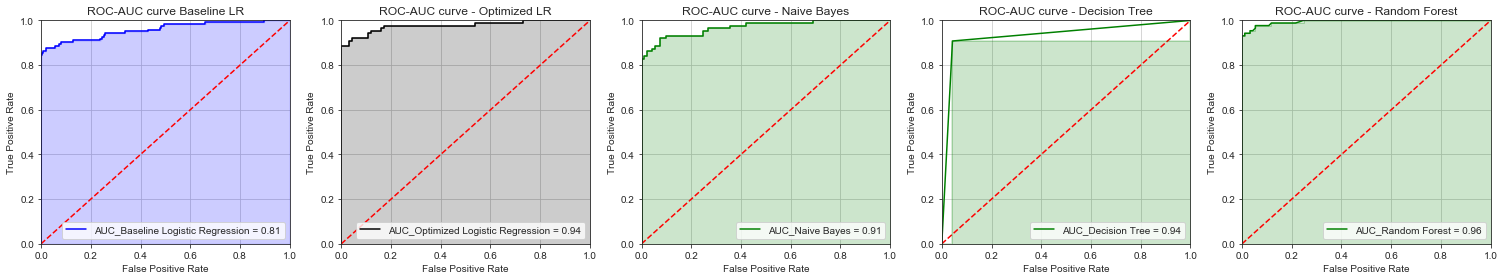

In [36]:
fig, axList = plt.subplots(ncols=5)
fig.set_size_inches(21,4)

# Plot the ROC-AUC curve for Baseline Logistic Regression
ax = axList[0]
lr = lr.fit(X_train, y_train.values.ravel()) 
lr_predicted_label_r = lr.predict_proba(X_test)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test, lr_predicted_labels)
    ax.plot(fpr, tpr, color = 'blue', label = 'AUC_Baseline Logistic Regression = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='blue', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='blue')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC-AUC curve Baseline LR')       
    
plot_auc(y_test, lr_predicted_label_r)
ax.grid(True)

# Plot the ROC-AUC curve for Optimized Logistic Regression
ax = axList[1]
opt_lr = opt_lr.fit(X_train_clean, y_train_clean.values.ravel()) 
opt_lr_predicted_label_r = opt_lr.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, opt_lr_predicted_labels)
    ax.plot(fpr, tpr, color = 'black', label = 'AUC_Optimized Logistic Regression = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='black', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='black')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC-AUC curve - Optimized LR') 
    
plot_auc(y_test_clean, opt_lr_predicted_label_r);
ax.grid(True)

# Plot the ROC-AUC curve for Naive Bayes
ax = axList[2]
nb = nb.fit(X_train_clean, y_train_clean.values.ravel()) 
nb_predicted_label_r = nb.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, nb_predicted_labels)
    ax.plot(fpr, tpr, color = 'green', label = 'AUC_Naive Bayes = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='green', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='green')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC-AUC curve - Naive Bayes') 
    
plot_auc(y_test_clean, nb_predicted_label_r);
ax.grid(True)

# Plot the ROC-AUC curve for Decision Tree
ax = axList[3]
dt = dt.fit(X_train_clean, y_train_clean.values.ravel()) 
dt_predicted_label_r = dt.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, dt_predicted_labels)
    ax.plot(fpr, tpr, color = 'green', label = 'AUC_Decision Tree = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='green', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='green')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC-AUC curve - Decision Tree') 
    
plot_auc(y_test_clean, dt_predicted_label_r);
ax.grid(True)

# Plot the ROC-AUC curve for Random Forest
ax = axList[4]
rf = rf.fit(X_train_clean, y_train_clean.values.ravel()) 
rf_predicted_label_r = rf.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, rf_predicted_labels)
    ax.plot(fpr, tpr, color = 'green', label = 'AUC_Random Forest = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='green', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='green')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC-AUC curve - Random Forest') 
    
plot_auc(y_test_clean, rf_predicted_label_r);
ax.grid(True)

plt.tight_layout()

## Conclusion

### Comparison between SMOTE and RUS Accuracy rate

|**Classifier**|SMOTE - Accuracy rate(%)|RUS - Accuracy rate(%)|
| :---|:---|:---|
|**Baseline Logistic Regression**|Train 99.92, Test 99.91|Train 99.92, Test 99.91|
|**Optimized Logistic Regression**|Train 98.75, Test 98.78|Train 98.17, Test 97.65|
|**Naive Bayes**|Train 90.28, Test 90.37|Train 91.38, Test 91.11|
|**Decision Tree**|Train 100, Test 99.85|Train 100, Test 93.88|
|**Random Forest**|Train 100, Test 99.98|Train 100, Test 96.11|

Compare to the result with SMOTE techique, the performance of the 5 models are indeed very similar when using Random Unders Sampling method. 

There are some differences in the performance of Decision Tree and Random Forest. When looking at Precision-Recall Curve and ROC Curve and AUC, the top-left corner of plot of Decision Tree and Random Forest models are no longer zero. Also, the accuracy rate of these 2 models both drop from 99% to 93% and 96% on test data only. 

Nonetheless, both SMOTE and Random Under Sampling methods are able to lead to the same conclusion that Random Forest model has the best performance among 5 classifiers. 